In [1]:
import re
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns # Import Seaborn
from shapely.geometry import box
import rasterio
from rasterio.plot import show
from rasterio.mask import mask

raster_filepath = "data/elevation/GMRT.tif"

In [2]:
def fetch_from_naturalearth():
    url = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
        # Read the file directly from the URL. GeoPandas can handle zip files directly.
    try:
        world = gpd.read_file(url)
    except Exception as e:
        raise e
    return world


def parse_lat_lon(lat_lon_str):
    parts = lat_lon_str.split()
    if len(parts) != 4:
        # Handle cases where the format might not be as expected
        print(f"Warning: Unexpected lat_lon format: '{lat_lon_str}'. Skipping.")
        return None, None

    lat_val = float(parts[0])
    lat_dir = parts[1]
    lon_val = float(parts[2])
    lon_dir = parts[3]

    if lat_dir == 'S':
        lat_val *= -1
    if lon_dir == 'W':
        lon_val *= -1

    return lat_val, lon_val


def plot_elevation_raster(ax, raster_filepath, land_polygons_gdf):
    with rasterio.open(raster_filepath) as src:
        print(f"Original Elevation Raster Info:")
        print(f"  Dimensions: {src.width}x{src.height}")
        print(f"  Bounds: {src.bounds}")
        print(f"  CRS: {src.crs}")
        print(f"  NoData: {src.nodata}")

        # --- CRITICAL STEP: Mask the raster to the land polygons ---
        # Reproject land polygons to raster's CRS if they don't match
        if land_polygons_gdf.crs != src.crs:
            print(f"Reprojecting land polygons from {land_polygons_gdf.crs} to raster's CRS ({src.crs})...")
            land_polygons_reprojected = land_polygons_gdf.to_crs(src.crs)
            print("Reprojection complete.")
        else:
            land_polygons_reprojected = land_polygons_gdf
            print("Land polygons and raster already in the same CRS.")

        # Get the geometries from the reprojected land GeoDataFrame
        geometries_for_mask = [geom for geom in land_polygons_reprojected.geometry]

        # Mask the raster: areas outside land polygons will become NoData
        # `filled=True` ensures masked-out areas are filled with `nodata` value
        nodata_val_for_mask = src.nodata if src.nodata is not None else -9999
        
        out_image, out_transform = mask(
            src,
            geometries_for_mask,
            crop=False, # Do NOT crop to the mask's bounding box, keep original extent
            all_touched=False,
            filled=True, # Fill areas outside mask with nodata_val_for_mask
            nodata=nodata_val_for_mask
        )

        # Replace the specific nodata value with NaN for Matplotlib transparency
        elevation_data_for_plot = np.where(out_image == nodata_val_for_mask, np.nan, out_image).squeeze()

        # Plot the elevation data
        im = show(
            elevation_data_for_plot,
            transform=out_transform,
            ax=ax,
            cmap='Greys',          # <--- CHANGED HERE: Use 'Greys' for grayscale elevation
            title=f"Elevation from GMRT ({raster_filepath.split('/')[-1]})"
        )
        

population_to_marker = {
    'A. jacksonii':  'o',   # Filled Circle
    'A. sp. T31':    'X',   # Filled X (thick cross)
    'A. sp. jack6':  (4, 0, 45),   # Filled Square
    'A. sp. jack5':  'P',   # Filled Plus sign (matches thick cross)
    'A. sp. jack3':  (4, 0, 0),   # Filled Diamond
    'A. sp. jack2':  (4, 1, 0),   # Unfilled Plus sign (4-point star) - inherently an outline
    'A. sp. jack1':  '^',   # Unfilled Star (6-point star) - inherently an outline
    'A. sp. F11':    (4, 1, 45),   # Unfilled X-mark (4-point star) - inherently an outline
}

sorted_unique_populations = list(population_to_marker.keys())

# Map population names to specific grayscale hex colors
# These are approximate shades to match the image
seaborn_greys_palette = sns.color_palette("Greys", n_colors=len(sorted_unique_populations), desat=1)

# Create the population_to_color dictionary dynamically
population_to_color = {
    pop: seaborn_greys_palette[i]
    for i, pop in enumerate(reversed(population_to_marker.keys()))
}


In [3]:
samples = pd.read_csv("../data/samples/SraRunTable.csv")
samples['lat'], samples['lon'] = zip(*samples['lat_lon'].apply(parse_lat_lon))
samples["populations"] = samples["Organism"].apply(
    lambda x: re.sub("\'", "", re.sub("Amanita", "A.", x))
)
samples_gdf = gpd.GeoDataFrame(samples, geometry=gpd.points_from_xy(samples['lon'], samples['lat']))
samples_gdf.crs = "EPSG:4326"  # Set the coordinate reference system to WGS 84


Original Elevation Raster Info:
  Dimensions: 570x684
  Bounds: BoundingBox(left=-110.07428053602811, bottom=9.835529299816912, right=-69.92571946397187, top=50.093620165654585)
  CRS: EPSG:4326
  NoData: None
Land polygons and raster already in the same CRS.


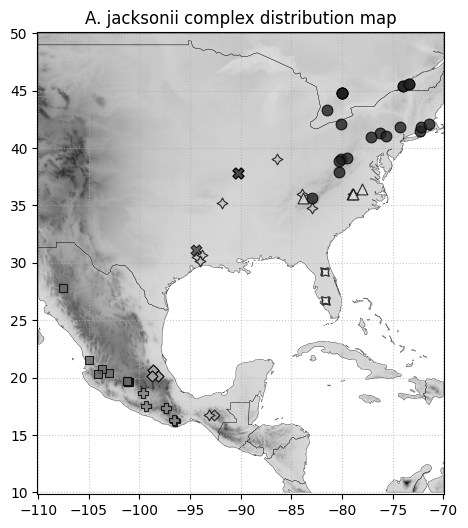

In [4]:
min_lon = -110
min_lat = 10
max_lon = -70
max_lat = 50

bbox_polygon = box(min_lon, min_lat, max_lon, max_lat)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs="EPSG:4326")

world = fetch_from_naturalearth()
clipped_world = gpd.clip(world, bbox_polygon)

if clipped_world.crs is None or clipped_world.crs.to_epsg() != 4326:
    clipped_world = clipped_world.to_crs(epsg=4326)

if bbox_gdf.crs != clipped_world.crs:
    bbox_gdf = bbox_gdf.to_crs(clipped_world.crs)

ocean_gdf = bbox_gdf.overlay(clipped_world, how='difference')

fig, ax = plt.subplots(figsize=(10, 6))

plot_elevation_raster(ax, raster_filepath, clipped_world)

ocean_gdf.plot(
    ax=ax,
    color='white',  # Set your desired ocean color (e.g., 'blue', '#ADD8E6' for light blue)
    edgecolor='none', # No border for the ocean fill
    zorder=0.5        # Plot just above the raster, but below land outlines and points
)

clipped_world.plot(
    ax=ax,
    color='none',         # Makes the interior of land polygons transparent
    edgecolor='black',  # Draws the black outlines of land
    linewidth=0.2,      # Standardize linewidth for clarity
    zorder=1            # Plot above the ocean fill and raster
)

ax.margins(0)

for population in sorted_unique_populations:
    subset = samples_gdf[samples_gdf['populations'] == population]
    current_marker = population_to_marker[population]
    assigned_color = population_to_color[population]
    subset.plot(
        ax=ax,
        marker=population_to_marker[population],
        color=population_to_color[population],
        markersize=60,       # Replicating s=60
        edgecolor='black',   # Replicating edgecolor='black'
        linewidth=0.8,       # Replicating linewidth=0.8
        alpha=0.8,
        zorder=2,
        label=population # This label will appear in the legend
    )

plt.title(f"A. jacksonii complex distribution map")
plt.grid(True, linestyle=':', alpha=0.7)
plt.savefig("../data/samples/distribution_map.svg")  # Save as SVG
plt.show()